<a href="https://colab.research.google.com/github/MDfarazuddin99/CNN_Pruning/blob/master/VGG_PRUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

import matplotlib.pyplot as plt


In [0]:

class cifar10vgg:
    def __init__(self,train=False):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('drive/My Drive/Colab Notebooks/cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=1)
        model.save_weights('cifar10vgg.h5')
        return model

In [0]:
from keras.datasets import cifar10 
(x_train,y_train),(x_test,y_test) =  cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
my_vgg = cifar10vgg()
x_train,x_test = my_vgg.normalize(x_train,x_test)



In [26]:
my_vgg.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)       

In [0]:
my_model_vgg = my_vgg.model 

In [0]:
def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers[0:len(all_dense_layers)-1]

In [0]:
def my_get_all_conv_layers(model,first_time):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)

    return all_conv_layers if (first_time==True) else all_conv_layers[1:]

In [0]:
all_conv_layers = my_get_all_conv_layers(my_model_vgg,True)

In [31]:
all_conv_layers

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]

In [0]:
def my_in_dense_layers_get_L1_norms_sorted_indices_and_values(model,graph):
    weights = list()
    all_dense_layers = my_get_all_dense_layers(model)
    for i in all_dense_layers:
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices_dense = list()
    layer_wise_filter_sorted_values_dense = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,:])
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,j]))
            neuron = 'neuron {}'.format(j)
            weights_dict[neuron] = weights_sum
            # print(weights_dict[neuron])
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        weight_values = list()
        neuron_indices = list()
        for element in weights_dict_sorted:
            neuron_indices.append(int(element[0][6:]))
            weight_values.append(element[1])
        layer_wise_filter_sorted_indices_dense.append(neuron_indices)
        layer_wise_filter_sorted_values_dense.append(weight_values)

        if graph == True:
                    x = np.arange(num_filters)
                    plt.figure(i+1,figsize=(7,5))
                    plt.plot(x,np.array(weight_values))
                    plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                    for j in range(len(layer_wise_filter_sorted_values_dense[i])):
                        if(np.mean(np.array(weight_values)) < weight_values[j]):
                            plt.axvline(x=j,c='r')
                            break

                    plt.xlabel('filter number')
                    plt.ylabel('L1 norm')
                    plt.title('Conv2d_{}'.format(i+1))
                    plt.grid(True)
                    plt.style.use(['classic'])        

    return layer_wise_filter_sorted_indices_dense,layer_wise_filter_sorted_values_dense

In [0]:
def plot_histogram_l1_norms_dense(model):
    _,a = my_in_dense_layers_get_L1_norms_sorted_indices_and_values(my_model_vgg,False)
    all_dense_layers = my_get_all_dense_layers(model)
    for i in range(len(all_dense_layers)):     
        plt.figure(i,figsize=(7,7))
        plt.hist(a[i-1],density=1, bins=150) 
        plt.xlabel('L1 Norms of dense_{}'.format(i+1))
        plt.ylabel('Probability')
        plt.style.use(['classic'])        

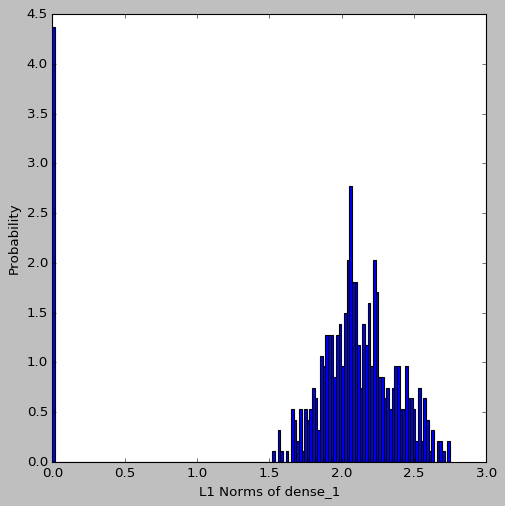

In [34]:
plot_histogram_l1_norms_dense(my_model_vgg)

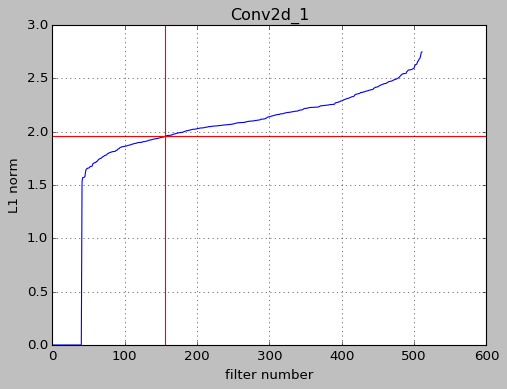

In [35]:
a,b = my_in_dense_layers_get_L1_norms_sorted_indices_and_values(my_model_vgg,True)

In [0]:
def my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,graph,first_time):
    weights = list()
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    for i in all_conv_layers:
        # print('{}th layer'.format(i),all_conv_layers)
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,0,0,:])
        # print(num_filters)
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,:,:,j]))
            filtr = 'filter {}'.format(j)
            weights_dict[filtr] = weights_sum
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        # print('L1 norm of conv2D_{} layer'.format(i+1),weights_dict_sorted)

        weight_values = list()
        filter_indices = list()

        for element in weights_dict_sorted:
            filter_indices.append(int(element[0][6:]))  # extracting the index of filter from string (tentative try to come up with better code)
            weight_values.append(element[1]) 
    
        layer_wise_filter_sorted_indices.append(filter_indices)
        layer_wise_filter_sorted_values.append(weight_values)

        if graph == True:
                x = np.arange(num_filters)
                plt.figure(i+1,figsize=(7,7))
                plt.plot(x,np.array(weight_values))
                plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                for j in range(len(layer_wise_filter_sorted_values[i-1])):
                    if(np.mean(np.array(weight_values)) < weight_values[j]):
                        plt.axvline(x=j,c='r')
                        break
                plt.style.use(['classic'])  


                plt.xlabel('filter number')
                plt.ylabel('L1 norm')
                plt.title('Conv2d_{}'.format(i+1))
                plt.grid(True)
                plt.style.use(['classic'])


    return layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values

In [0]:
def plot_histogram_l1_norms_conv(model,first_time):
    _,a = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(my_model_vgg,False,False)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    for i in range(len(all_conv_layers)):     
        plt.figure(i,figsize=(7,7))
        plt.hist(a[i-1],density=1, bins=150) 
        plt.xlabel('L1 Norms of conv_2d_{}'.format(i+1))
        plt.ylabel('Probability')
        plt.style.use(['classic'])        

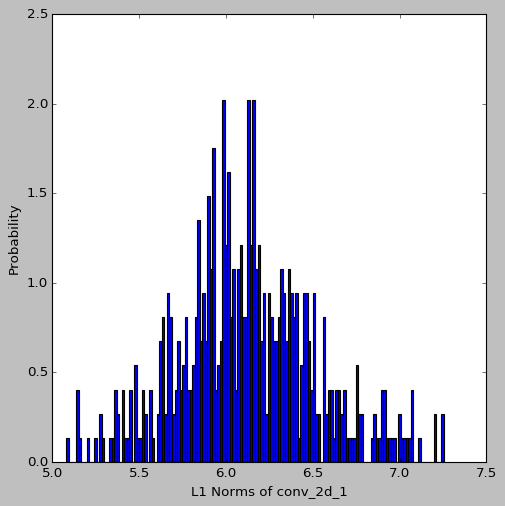

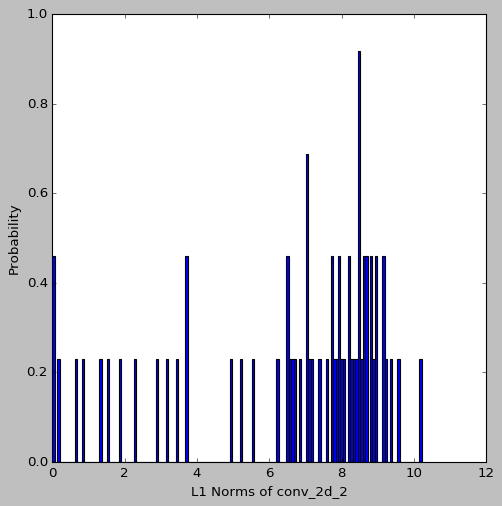

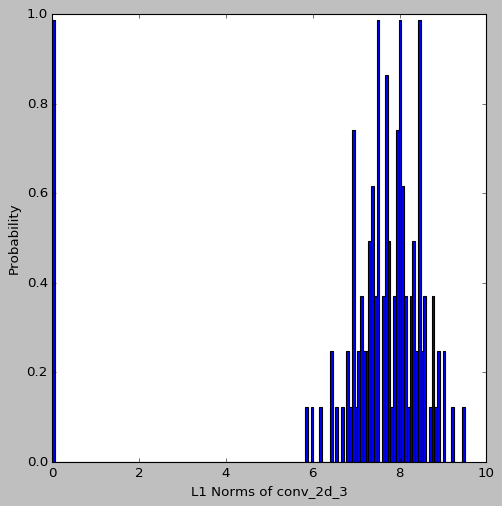

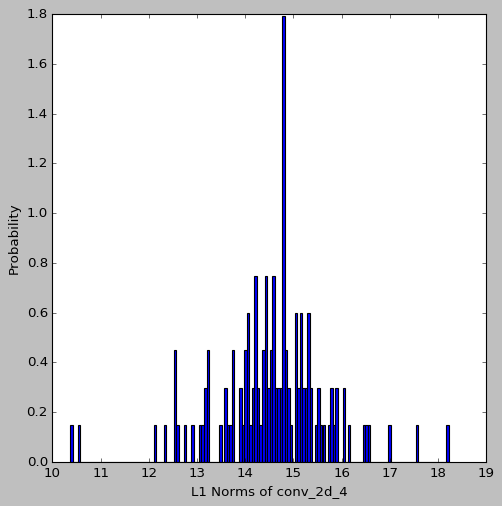

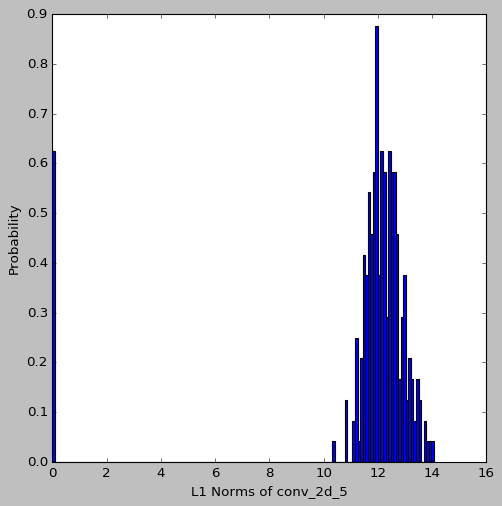

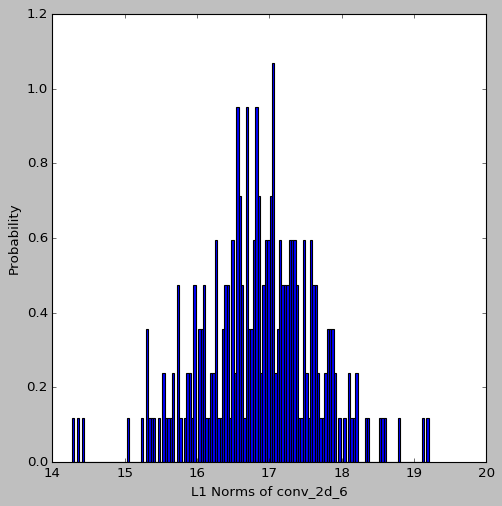

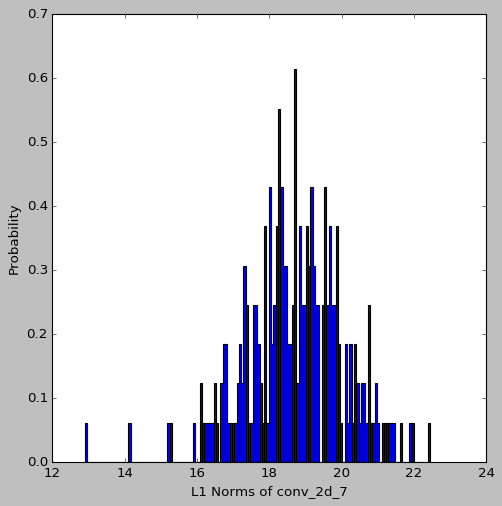

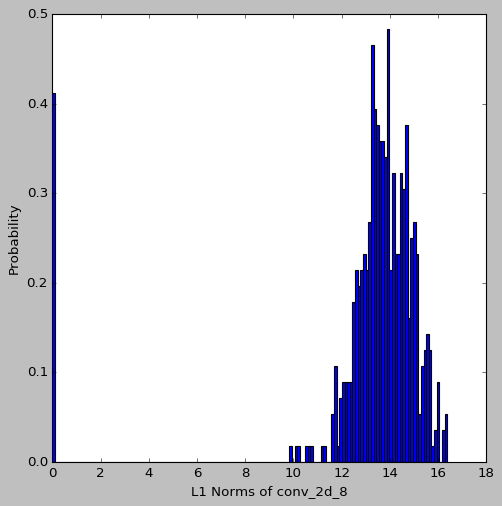

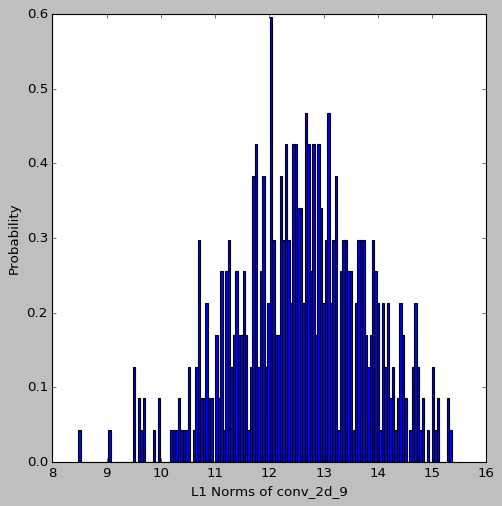

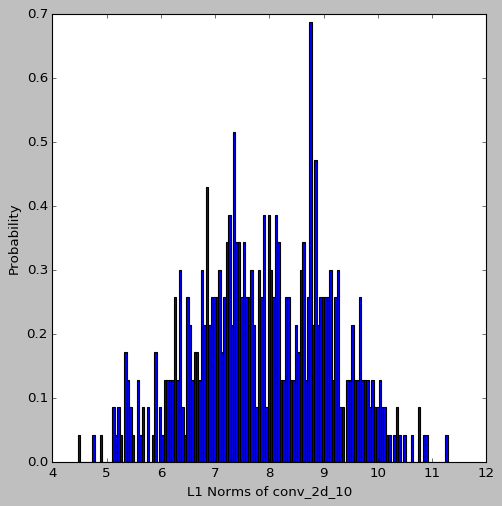

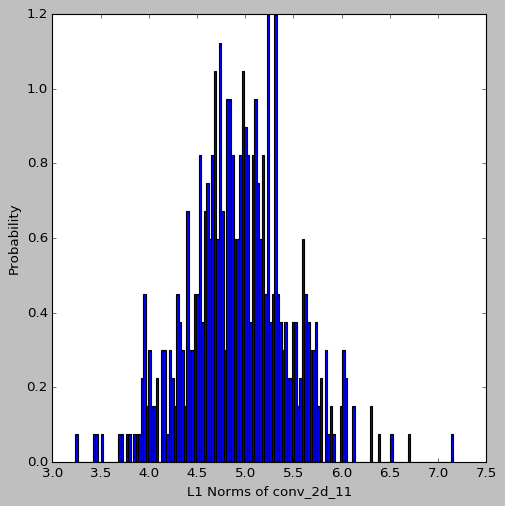

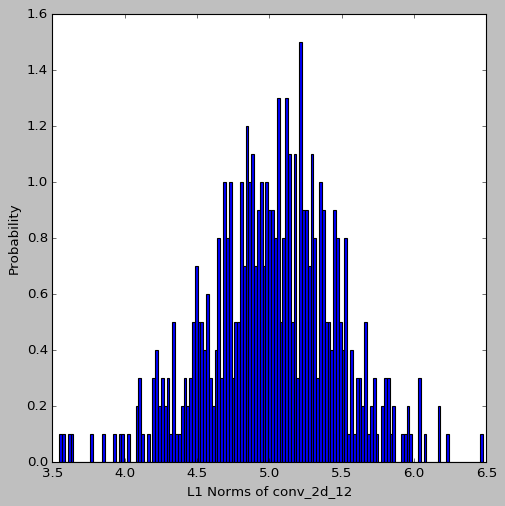

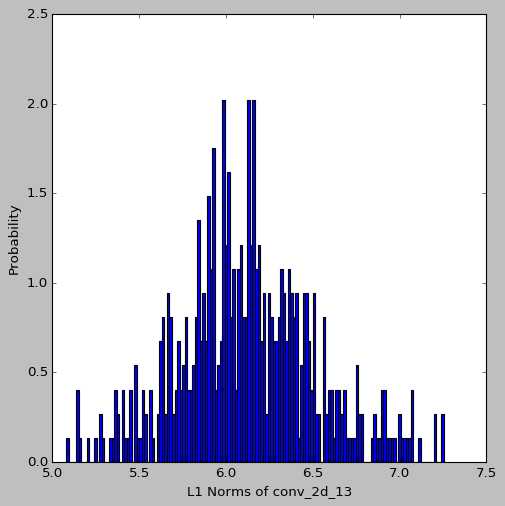

In [38]:
plot_histogram_l1_norms_conv(my_model_vgg,True)

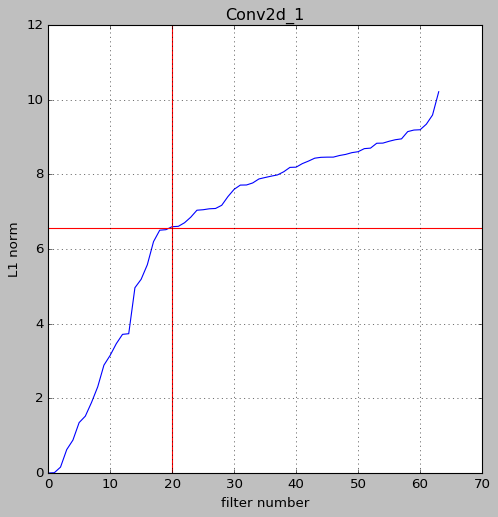

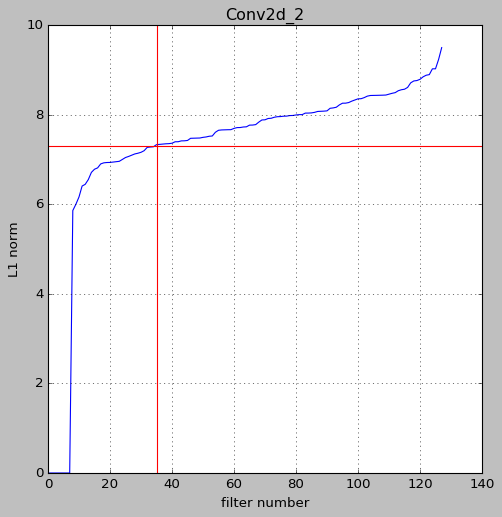

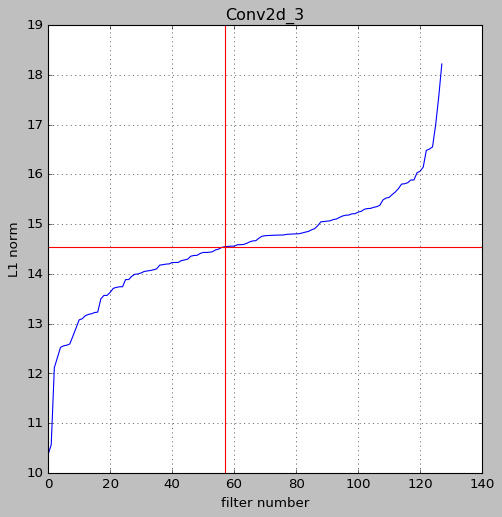

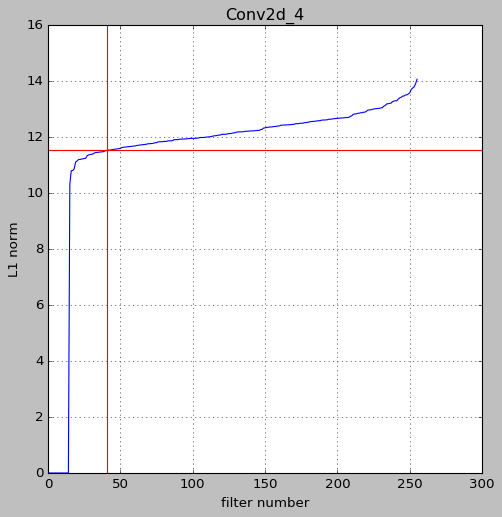

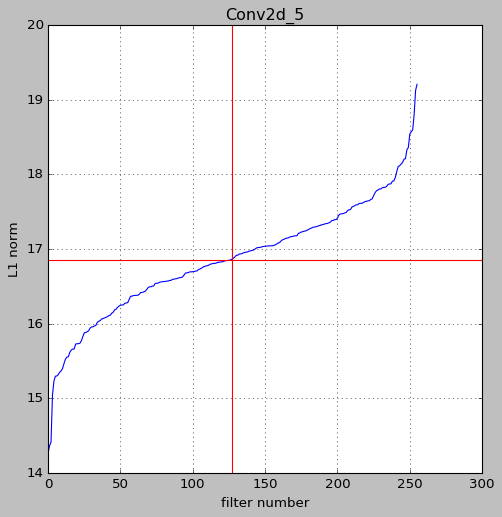

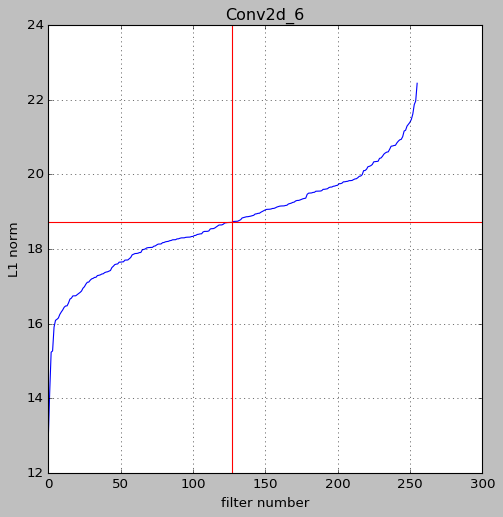

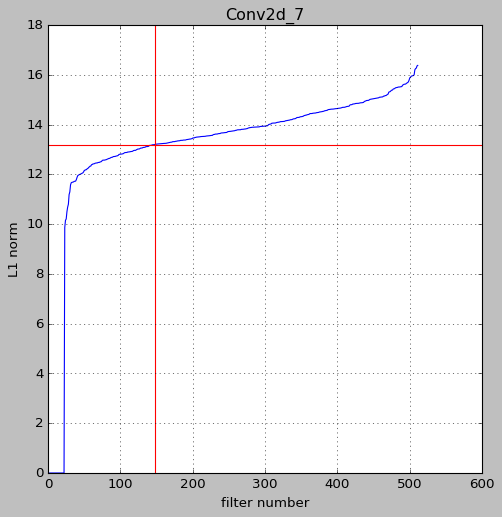

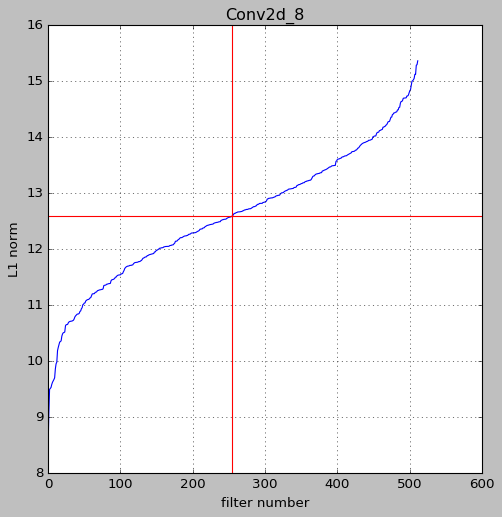

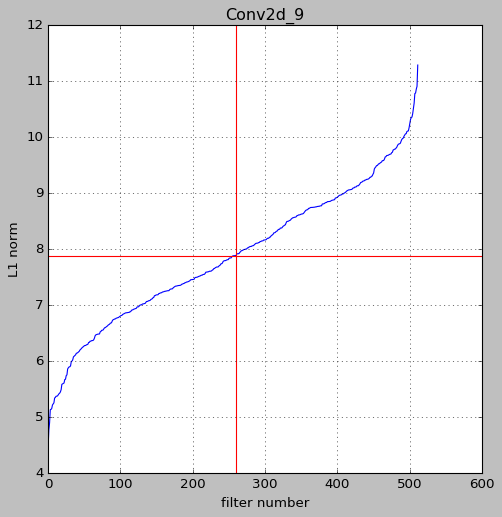

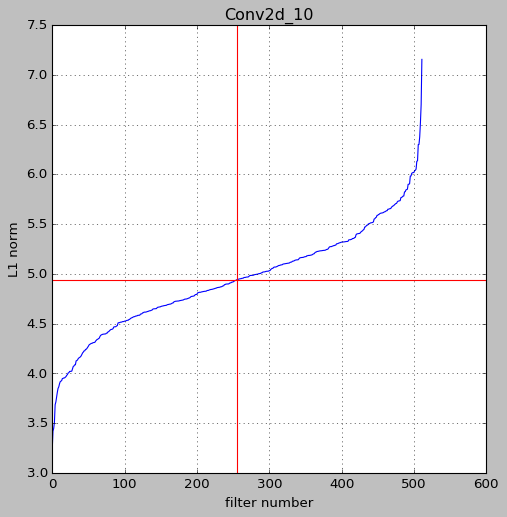

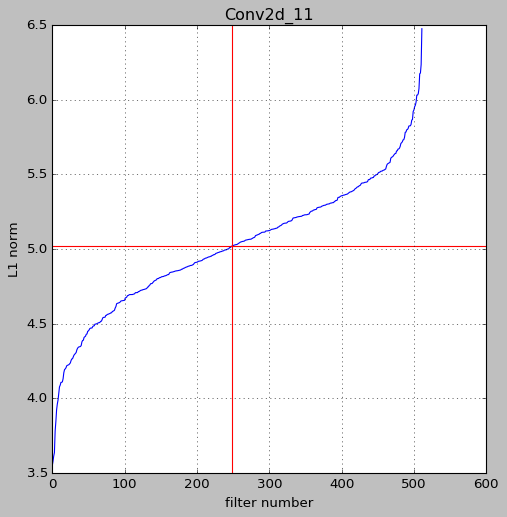

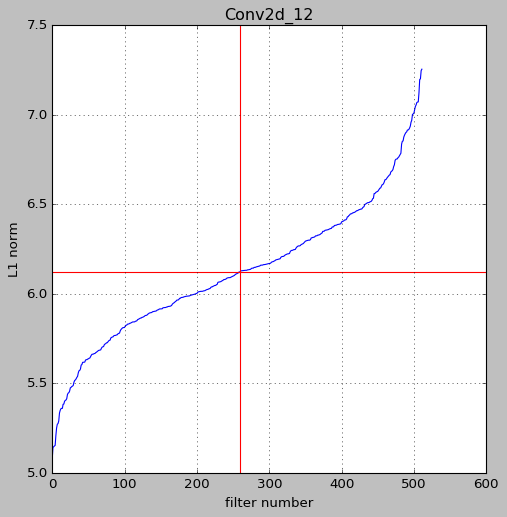

In [39]:
a,b = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(my_model_vgg,True,False)

In [40]:
def my_get_prune_neuron_indices(model):
    layer_wise_neuron_sorted_indices,layer_wise_neuron_sorted_values = my_in_dense_layers_get_L1_norms_sorted_indices_and_values(model,False)
    all_dense_layers = my_get_all_dense_layers(model)
    thresh_hold_means = list()
    for i in range(len(all_dense_layers)):
        thresh_hold_means.append(np.mean(np.array(layer_wise_neuron_sorted_values[i])))
    prune_neuron_indices = list()
    for i in range(len(all_dense_layers)):
        for j in range(len(layer_wise_neuron_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_neuron_sorted_values[i][j]):
                prune_neuron_indices.append(j)
                break
    return prune_neuron_indices
prune_neuron_indices = my_get_prune_neuron_indices(my_model_vgg)
prune_neuron_indices

[156]

In [41]:
def my_get_prune_filter_indices(model,first_time ):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model, False,first_time)
    all_conv_layers = my_get_all_conv_layers(model,first_time)
    thresh_hold_means = list()
    for i in range(len(all_conv_layers)):
        # print(i,'/',len(all_conv_layers))
        thresh_hold_means.append(np.mean(np.array(layer_wise_filter_sorted_values[i])))
    prune_filter_indices = list()
    for i in range(len(all_conv_layers)):
        for j in range(len(layer_wise_filter_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_filter_sorted_values[i][j]):
                prune_filter_indices.append(j)
                break
    return prune_filter_indices
prune_filter_indices = my_get_prune_filter_indices(my_model_vgg,True)
prune_filter_indices

[30, 20, 35, 57, 41, 127, 127, 148, 254, 260, 255, 248, 259]

In [0]:
def my_delete_filters(model,first_time):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False,first_time)
    
    layer_wise_neuron_sorted_indices,layer_wise_neuron_sorted_values_ = my_in_dense_layers_get_L1_norms_sorted_indices_and_values(model,False)

    prune_filter_indices = my_get_prune_filter_indices(model,first_time)
    
    neuron_filter_indices = my_get_prune_neuron_indices(model)

    all_conv_layers = my_get_all_conv_layers(model,first_time)

    all_dense_layers = my_get_all_dense_layers(model)
    # print(all_conv_layers)
    surgeon = Surgeon(model)
    for index,value in enumerate(all_conv_layers):
        # print(value,index,prune_filter_indices[index])
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_filter_sorted_indices[index][0:prune_filter_indices[index]])
    
    for index,value in enumerate(all_dense_layers):
        # print(value,index,prune_filter_indices[index])
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_neuron_sorted_indices[index][0:prune_neuron_indices[index]])


    model_new = surgeon.operate()
    return model_new


In [43]:

!pip install kerassurgeon
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [0]:
# # This is temporary code cell you may delete it 
# my_new_model = my_vgg.model
# my_new_model = my_delete_filters(my_new_model,first_time=True)

In [0]:
 # model= load_model('drive/My Drive/Colab Notebooks/model2_before_pruning.h5')
model = my_vgg.model
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

validation_accuracy = model.evaluate(x_test,y_test)[1]
print(validation_accuracy)
max_val_acc = validation_accuracy
count = 0
all_models = list()
while max_val_acc <= validation_accuracy   :
    print("ITERATION {} ".format(count))
    all_models.append(model)
    if max_val_acc < validation_accuracy:
        max_val_acc = validation_accuracy

    if count < 1:
        model = my_delete_filters(model,True)
        
    else:
        model = my_delete_filters(model,False)    
    model = my_vgg.train(model)
    validation_accuracy = model.evaluate(x_test,y_test)[1]
    print("VALIDATION ACCURACY AFTER {} ITERATIONS = {}".format(count,validation_accuracy))
    count+=1

10000/10000 [==============================] - 7s 731us/step
0.9359
ITERATION 0 
Deleting 30/64 channels from layer: conv2d_14
Deleting 20/64 channels from layer: conv2d_15
Deleting 35/128 channels from layer: conv2d_16
Deleting 57/128 channels from layer: conv2d_17
Deleting 41/256 channels from layer: conv2d_18
Deleting 127/256 channels from layer: conv2d_19
Deleting 127/256 channels from layer: conv2d_20
Deleting 148/512 channels from layer: conv2d_21
Deleting 254/512 channels from layer: conv2d_22
Deleting 260/512 channels from layer: conv2d_23
Deleting 255/512 channels from layer: conv2d_24
Deleting 248/512 channels from layer: conv2d_25
Deleting 259/512 channels from layer: conv2d_26
Deleting 156/512 channels from layer: dense_3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/250
390/390 [==============================] - 38s 97ms/step - loss: 3.1985 - acc: 0.2980 - val_loss: 2.6383 - val_acc: 0.3767
Epoch 2/250
269/390 [===================>..........] - ETA: 9s - loss: 2.3434 - acc: 0.4338 